# ML baseline

## import packages

In [1]:
import numpy as np 
import pandas as pd 
import time
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel as C)

import joblib

from xgboost import XGBRegressor

import tensorflow as tf
from keras.layers import Dropout, Dense, BatchNormalization, GaussianDropout, GaussianNoise, LeakyReLU
lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.1)
from keras import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from livelossplot.keras import PlotLossesCallback
from keras.constraints import MinMaxNorm
from keras.initializers import Constant
from keras.optimizers import Adam



import matplotlib.pyplot as plt 
%matplotlib inline

import sys
sys.path.append('../')
from colorml.utils import mapping_to_target_range, get_timestamp_string, plot_predictions, huber_fn, mapping_to_target_range_sig
from colorml.descriptornames import * 

RESULTS = os.path.join('..', 'results', 'baselines')
MODELS = os.path.join('..', 'models', 'baselines')
from numpy.random import seed
seed(821996)

ModuleNotFoundError: No module named 'xgboost'

## import and merge data 

In [ ]:
df_survey = pd.read_csv('../data/cleaned_survey.csv')

In [ ]:
df_annotated = pd.read_csv('../data/annotated_df.csv')

In [ ]:
df_core_test = pd.read_csv('../data/CoRE12K_testdata.csv')
df_core_train = pd.read_csv('../data/CoRE12K_traindata.csv')

df_core = pd.concat([df_core_test, df_core_train])

In [ ]:
df_survey.head()

In [ ]:
df_annotated.head()

In [ ]:
df_core.head()

In [ ]:
df_annotated['MOFname'] = [n + '_clean' for n in df_annotated['refcode']]
df_merged = df_annotated.merge(df_core, left_on='MOFname', right_on='MOFname')

In [ ]:
df_mol = pd.read_csv('../data/moldesc.csv')

In [ ]:
df_mol.head()

In [ ]:
df_merged.head()

In [ ]:
df_merged_merged = pd.merge(df_merged, df_mol, left_on='MOFname', right_on='name')

In [ ]:
df_merged

In [2]:
CHEMICAL_FEATURES = metalcenter_descriptors + functionalgroup_descriptors + linker_descriptors  + mol_desc + summed_linker_descriptors + summed_metalcenter_descriptors + summed_functionalgroup_descriptors

NameError: name 'metalcenter_descriptors' is not defined

In [15]:
df_merged_merged['color_cleaned'] = [str(c).replace('-', ' ').strip() for c in df_merged_merged['color']]

In [16]:
overlapping_colors = set(df_merged_merged['color_cleaned'].unique()) & set(df_survey['color_string'].unique())

In [17]:
len(overlapping_colors)

123

In [18]:
df_subset = df_merged_merged[CHEMICAL_FEATURES + ['color_cleaned']]

In [19]:
df_color_mapping = pd.read_csv('../data/cleaned_survey_unweighted_median.csv')

In [20]:
df_color_mapping.head()

,color_string,delta_t_seconds,r,g,b
0,amaranthine,29.585808,164.5,39.0,127.5
1,amber,32.768951,219.0,143.0,20.0
2,aquamarine,15.822536,57.0,186.0,197.0
3,aubergine,19.335506,56.0,22.0,88.5
4,azure,14.913123,45.0,167.0,225.5


In [21]:
df_subset_merged = df_subset.merge(df_color_mapping, left_on='color_cleaned', right_on='color_string')

In [22]:
df_subset_merged.tail()

,mc_CRY-chi-0-all,mc_CRY-chi-1-all,mc_CRY-chi-2-all,mc_CRY-chi-3-all,mc_CRY-Z-0-all,mc_CRY-Z-1-all,mc_CRY-Z-2-all,mc_CRY-Z-3-all,mc_CRY-I-0-all,mc_CRY-I-1-all,...,sum-D_func-alpha-0-all,sum-D_func-alpha-1-all,sum-D_func-alpha-2-all,sum-D_func-alpha-3-all,color_cleaned,color_string,delta_t_seconds,r,g,b
6410,5.108425,34.7784,20.158675,86.624362,4659.25,2482.00,17679.375,6179.75,1.0,4.375,...,0.0,-52.8,-37.333333,-95.2,wheat,wheat,18.112884,224.0,201.0,104.0
6411,3.145975,29.3170,32.018275,79.484200,864.75,1114.75,1947.500,2588.00,1.0,5.000,...,0.0,650.1,0.000000,0.0,ruby red,ruby red,20.483727,197.5,9.0,22.5
6412,3.610000,21.6600,28.462000,50.730000,841.00,3480.00,2436.000,4524.00,1.0,4.000,...,0.0,0.0,0.000000,0.0,black brown,black brown,32.576774,62.5,40.5,13.0
6413,2.656900,33.6432,19.282900,39.054800,529.00,1104.00,1081.000,1288.00,1.0,6.000,...,0.0,0.0,0.000000,0.0,black brown,black brown,32.576774,62.5,40.5,13.0
6414,3.534400,37.2992,28.764000,45.308000,729.00,1242.00,972.000,1080.00,1.0,6.000,...,0.0,-21.8,-35.400000,-54.0,red purple,red purple,21.367428,198.0,20.5,96.0


In [23]:
df_subset_merged.to_csv('../data/color_feat_merged.csv')

## Build at multitask baseline without augmentation.

ToDo: Check class distributions and use reasonable stratification.

In [159]:
X_df = df_subset_merged[CHEMICAL_FEATURES]
y_df = df_subset_merged[['r', 'g', 'b']]
X_train, X_test, y_train, y_test, name_train, name_test = train_test_split(X_df, y_df, df_subset_merged['color_cleaned'], train_size=0.7)

In [160]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [161]:
X_train.shape

(5160, 156)

In [188]:
timestamp = get_timestamp_string()
mlp = Sequential()
mlp.add(GaussianNoise(0.2, input_shape=(X_train.shape[1],)))
mlp.add(Dense(64, activation=lrelu, 
              kernel_initializer='he_normal'))
mlp.add(GaussianDropout(0.2))
mlp.add(Dense(32,  activation=lrelu, 
             kernel_initializer='he_normal'))  
mlp.add(GaussianDropout(0.2))
mlp.add(Dense(16,  activation=lrelu, 
             kernel_initializer='he_normal'))  
mlp.add(GaussianDropout(0.2))
mlp.add(Dense(8,  activation=lrelu, 
             kernel_initializer='he_normal'))
mlp.add(Dense(3, activation=mapping_to_target_range, kernel_initializer='he_normal'))


In [189]:
es = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=20, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

In [190]:
mlp.compile(optimizer=Adam(learning_rate=3e-3), loss=huber_fn, metrics=['mae', 'mean_absolute_percentage_error'])

Epoch 2/500
  50/4128 [..............................] - ETA: 0s - loss: 80.4168 - mae: 80.9160 - mean_absolute_percentage_error: 8458069504.0000

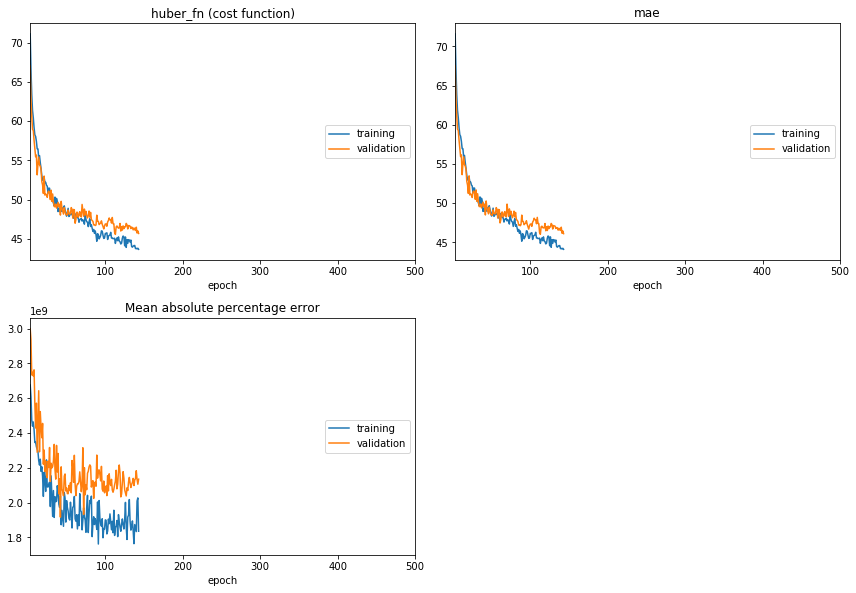

Epoch 143/500
4128/4128 [==============================] - 2s 427us/step - loss: 43.6953 - mae: 44.1280 - mean_absolute_percentage_error: 1835578624.0000 - val_loss: 45.7118 - val_mae: 46.1251 - val_mean_absolute_percentage_error: 2134785920.0000


In [191]:
mlp.fit(X_train, y_train, epochs=500, batch_size=50, callbacks=[learning_rate_reduction, es, PlotLossesCallback(plot_extrema=False)], validation_split=0.2)

In [181]:
joblib.dump(mlp, os.path.join(MODELS, '_'.join([timestamp, 'mlp_constrained_output.joblib'])))

['../models/baselines/Feb-26-2020_0943_mlp_constrained_output.joblib']

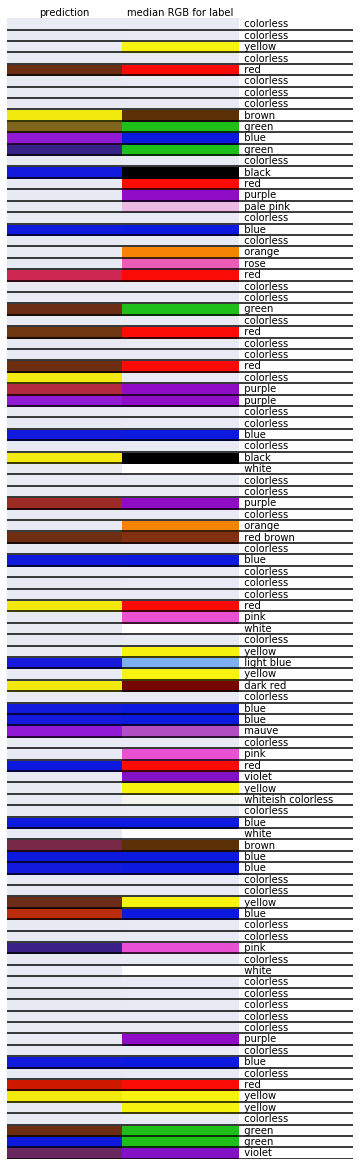

In [182]:
predictions = mlp.predict(X_train)
plot_predictions(predictions, y_train.values,  name_train.values,  sample=100, outname=os.path.join(MODELS, '_'.join([timestamp, 'mlp_constrained_output_TRAIN.pdf'])))

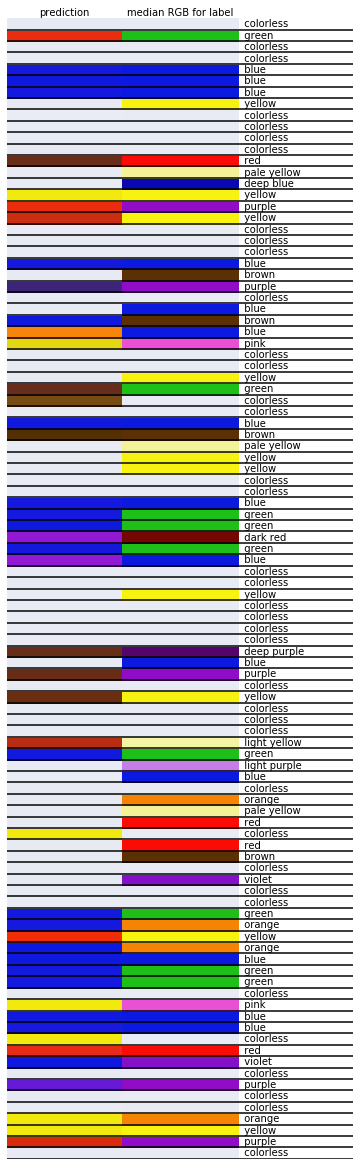

In [183]:
predictions = mlp.predict(X_test)
plot_predictions(predictions, y_test.values,  name_test.values,  sample=100, outname=os.path.join(MODELS, '_'.join([timestamp, 'mlp_constrained_output_TEST.pdf'])))

## Build a simple knn

In [29]:
N=2
timestamp = get_timestamp_string()
knn = KNeighborsRegressor(N)
pipe = Pipeline(
    [   
        ('vt', VarianceThreshold(0.8)),
        ('knn', knn)
    ]
)
pipe.fit(X_train, y_train)
joblib.dump(pipe, os.path.join(MODELS, '_'.join([timestamp, 'knn_{}.joblib'.format(N)])))

['../models/baselines/Feb-25-2020_1832_knn_2.joblib']

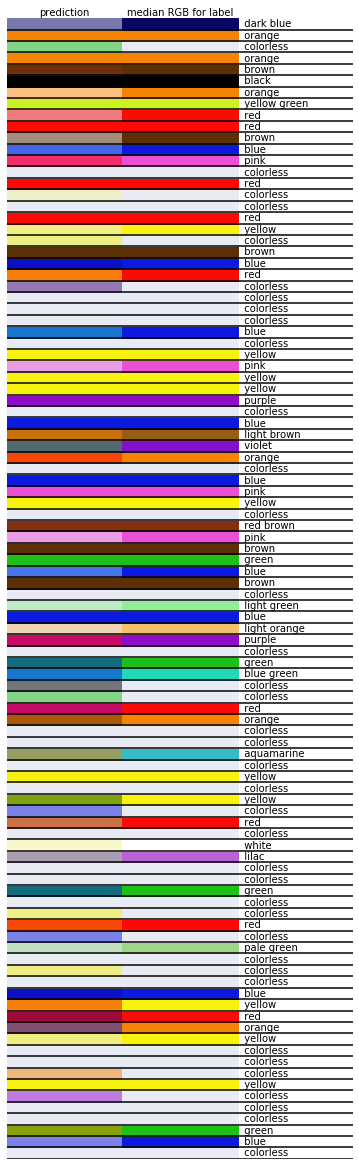

In [30]:
predictions = pipe.predict(X_train)
plot_predictions(predictions, y_train.values,  name_train.values,  sample=100, outname=os.path.join(MODELS, '_'.join([timestamp, 'knn_{}_TRAIN.pdf'.format(N)])))

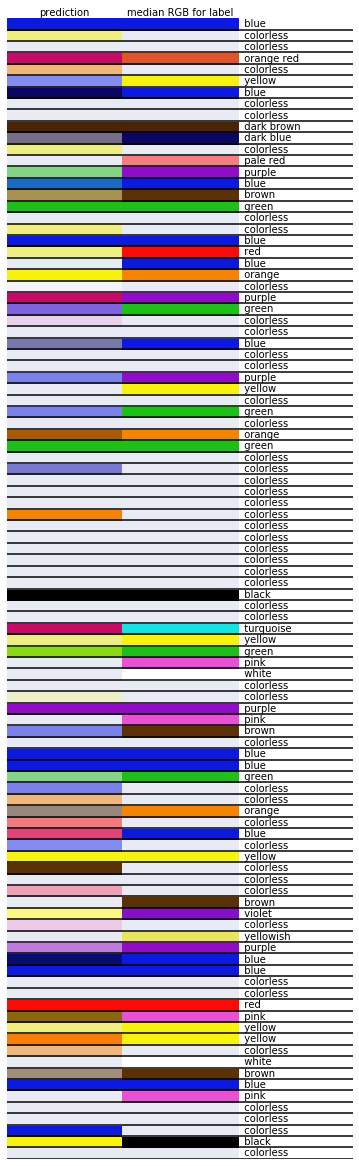

In [31]:
predictions = pipe.predict(X_test)
plot_predictions(predictions, y_test.values,  name_test.values,  sample=100, outname=os.path.join(MODELS, '_'.join([timestamp, 'knn_{}_TEST.pdf'.format(N)])))

In [206]:
gp_kernel =   RBF(1, (1e-3, 1e1)) + C(0, (1e-1, 1e1))
gp = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=9)

gp_pipe = Pipeline(
    [
        ('vt', VarianceThreshold(0.7)), 
        ('gp', gp)
    ]
)

gp_pipe.fit(X_train, y_train)

In [ ]:
predictions = gp_pipe.predict(X_train)
plot_predictions(predictions, y_train.values,  name_train.values, sample=100, outname=os.path.join(MODELS, '_'.join([timestamp, 'gp_{}_TRAIN.pdf'.format(N)])))

In [ ]:
predictions = gp_pipe.predict(X_test)
plot_predictions(predictions, y_test.values,  name_test.values, sample=100, outname=os.path.join(MODELS, '_'.join([timestamp, 'gp_{}_TEST.pdf'.format(N)])))